# Questão:

![](https://i.imgur.com/0i7xBi2.png)

[link 1](https://www.guiadaengenharia.com/programacao-semaforo/)

[link 2](https://www.maxwell.vrac.puc-rio.br/2695/2695.PDF)

## Conceitos básicos
Para iniciarmos, precisamos conhecer alguns conceitos fundamentais a respeito dos semáforos, são eles:

**Ciclo:** é o tempo necessário à uma sequência completa de indicações luminosas, ou seja, é o tempo em que a sequência verde, amarelo e vermelho aparece por completo.

**Fase:** é a parte do ciclo reservada à uma combinação qualquer de movimentos de tráfego que recebem, simultaneamente, o direito de passagem.

**Estágio:** também conhecido como intervalo, é a parte do tempo de ciclo durante o qual não mudam as indicações luminosas.

![](https://www.guiadaengenharia.com/wp-content/uploads/2019/01/ciclo-2-fases.png)



In [5]:
import pandas as pd
import numpy as np

movimentos = ['1A', '1B', '2A', '2B']
fluxo_veiculos = [2400, 2200, 1250, 1000]

df = pd.DataFrame(data={'Movimentos': movimentos, 'Fluxo de veículos (veículo/h)': fluxo_veiculos})
df.set_index('Movimentos', inplace=True)
df

,Fluxo de veículos (veículo/h)
Movimentos,
1A,2400
1B,2200
2A,1250
2B,1000


Assumindo que a largura das na horizontal é 18m e a largura da vertical é 15m.

Utilizando as seguintes suposições:

- $T_a = 3s$ (é o tempo de amarelo (s), é geralmente entre 2 e 3s)
- $T_{vermelho,total} = 3s$
- $T_{percepção} = 3s$

Fórmulas usadas:

**Taxa de ocupação:**

$ y_i = \frac{q_i}{s_i}$

Onde:

- $ q_i $ é o fluxo na aproximação (veículo/h);
- $ s_i $ é o fluxo de saturação (veículo/h).
- $ y_i $ é a taxa de ocupação para a aproximação;

**Fluxo de saturação:**

$ s_i = 525*L $

Onde:

- $L$ é a largura da via;

**Taxa de ocupação da interseção:**
$Y = \sum_{}^{} y_i^*$

Onde:
- $y_i^*$ é a taxa máxima para cada estágio.

**Tempo perdido:**

$T_p = \sum_{}^{} T_{vermelho,total} + \sum_{}^{} T_{percepção}$,

**Tempo de ciclo:**

$T_{co} = \frac{1,5 * T_p + 5}{1-Y}$

**Tempo de verde efeito:**

$T_{v,ef,i} = y_i^* * (\frac{T_{co} - T_p}{Y})$

Onde:

$T_{v,ef,i}$ é o tempo de verde efetivo para cada estágio;

**Tempo de verde real:**

$T_{v,real,i} = T_{v,ef,i} + T_{percepção} - T_a$

In [6]:
T_a = 3
T_vemelho_total = 3
T_percepcao = 3

l1 = 18
l2 = 15

s1 = 525 * l1
s2 = 525 * l2

# Calculando as taxas de ocupações:
y_1a = round(df.loc['1A', 'Fluxo de veículos (veículo/h)']/s1, 2)
y_1b = round(df.loc['1B', 'Fluxo de veículos (veículo/h)']/s1, 2)
y_2a = round(df.loc['2A', 'Fluxo de veículos (veículo/h)']/s2, 2)
y_2b = round(df.loc['2B', 'Fluxo de veículos (veículo/h)']/s2, 2)

df['Taxa de ocupação'] = [y_1a, y_1b, y_2a, y_2b]
df

,Fluxo de veículos (veículo/h),Taxa de ocupação
Movimentos,,
1A,2400,0.25
1B,2200,0.23
2A,1250,0.16
2B,1000,0.13


In [7]:
# Taxa de ocupação da interseção:

max_values = [max(y_1a, y_1b), max(y_2a, y_2b)]
Y = round(sum(max_values), 2)
(max_values, Y)

([0.25, 0.16], 0.41)

In [8]:
# Tempo perdido:
T_p = T_vemelho_total + T_percepcao*2
T_p

9

In [9]:
# Tempo de ciclo:
T_co = round((1.5 * T_p + 5)/(1 - Y), 2)
T_co

31.36

In [10]:
# Tempo de verde efetivo:
T_v_ef = []
T_v_ef.append(round(max_values[0] * (T_co - T_p) / Y, 2))
T_v_ef.append(round(max_values[1] * (T_co - T_p) / Y, 2))
T_v_ef


[13.63, 8.73]

In [11]:
T_v_real = []
T_v_real.append(round(T_v_ef[0] + T_percepcao - T_a, 2))
T_v_real.append(round(T_v_ef[1] + T_percepcao - T_a, 2))
T_v_real

[13.63, 8.73]

In [12]:
result = pd.DataFrame(data = {'Tempo de verde efetivo': T_v_ef, 'Tempo de verde real': T_v_real}, index=np.arange(1, 3, 1))
result = result.rename_axis('Fase', axis='columns')
result

Fase,Tempo de verde efetivo,Tempo de verde real
1,13.63,13.63
2,8.73,8.73


# Fuzzificação:

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import warnings

warnings.filterwarnings('ignore')  # Ignora os avisos de warnings

## Definindo as variáveis de entrada do problema.

Text(0.5, 1.0, 'Sinal 1')

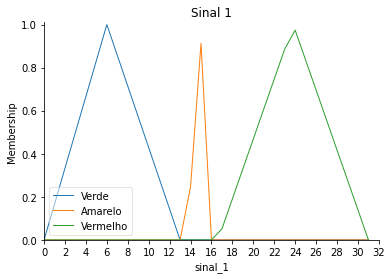

In [83]:
# 1. Sinal da via 1:
sinal_1 = ctrl.Antecedent(np.arange(0, int(T_co+1), 1), 'sinal_1')

sinal_1['Verde'] = fuzz.trimf(sinal_1.universe, [0, int(T_v_real[0]/2), int(T_v_real[0])])
sinal_1['Amarelo'] = fuzz.trimf(sinal_1.universe, [T_v_real[0], (2*T_v_real[0]+T_a)/2, int(T_v_real[0]+T_a)])
sinal_1['Vermelho'] = fuzz.trimf(sinal_1.universe, [T_v_real[0]+T_a, (T_v_real[0]+T_a+sinal_1.universe.max())/2, sinal_1.universe.max()])

sinal_1.view()
plt.xticks(np.arange(0, int(T_co+2), 2))
plt.title('Sinal 1')

Text(0.5, 1.0, 'Sinal 1')

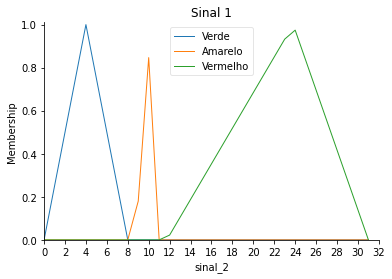

In [86]:
# 1. Sinal da via 1:
sinal_2 = ctrl.Consequent(np.arange(0, int(T_co+1), 1), 'sinal_2')

sinal_2['Verde'] = fuzz.trimf(sinal_2.universe, [0, int(T_v_real[1]/2), int(T_v_real[1])])
sinal_2['Amarelo'] = fuzz.trimf(sinal_2.universe, [T_v_real[1], (2*T_v_real[1]+T_a)/2, int(T_v_real[1]+T_a)])
sinal_2['Vermelho'] = fuzz.trimf(sinal_2.universe, [T_v_real[1]+T_a, (T_v_real[0]+T_a+sinal_2.universe.max())/2, sinal_2.universe.max()])

sinal_2.view()
plt.xticks(np.arange(0, int(T_co+2), 2))
plt.title('Sinal 1')


# Inferência

min -> And

Max -> OR

## Regras: 

In [88]:
regra1 = ctrl.Rule(sinal_1['Verde']  | sinal_1['Amarelo'], sinal_2['Vermelho'])
regra2 = ctrl.Rule(sinal_1['Amarelo'] | sinal_1['Vermelho'], sinal_2['Verde'])

sistema_controle = ctrl.ControlSystem([regra1, regra2])
sistema = ctrl.ControlSystemSimulation(sistema_controle)

sistema.input['Verde'] = 5
sistema.input['amarelo'] = 1
sistema.input['Vermelho'] = 25

sistema.compute()

print(f"Score: {sistema.output['sinal_2']:.2f}")

labels = ['Baixo', 'Médio', 'Alto', 'Centroid']

sinal_2.view(sim=sistema)
plt.title('Score')
plt.grid(color='green', linestyle = '--', linewidth = 0.5)
plt.legend(labels, bbox_to_anchor=(0,-0.3,1,0.2), loc='lower center', mode='expand', ncol=4)
plt.show()


ValueError: Unexpected input: Verde